# Logistic Regression Detect Deface Attack

* Prepare by **vomtung@gmail.com**

In [2]:
%pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Install Required Packages

First, we need to install the necessary Python packages for our machine learning pipeline.

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Import Required Libraries

We need several libraries for this document classification task:
- **pandas**: Data manipulation and analysis
- **numpy**: Numerical computing
- **sklearn**: Machine learning tools (TF-IDF, Logistic Regression, metrics)
- **matplotlib & seaborn**: Data visualization

In [4]:
train_df = pd.read_csv('dataset/train_data.csv')
test_df = pd.read_csv('dataset/test_data.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nTraining data columns: {train_df.columns.tolist()}")
print(f"\nLabel distribution in training data:")
print(train_df['Label'].value_counts())
print(f"\nSample data:")
print(train_df.head())

Training data shape: (1230, 2)
Test data shape: (307, 2)

Training data columns: ['HTML', 'Label']

Label distribution in training data:
Label
1    645
0    585
Name: count, dtype: int64

Sample data:
                                                HTML  Label
0  Vimeo Interactive Video Experience Platform   ...      0
1  \nHacked By Shield Iran ! \nHacked By \nShield...      1
2  HACKED BY INDIAN CYBER FORCE \nYOU GOT HACKED ...      1
3  Space.com: NASA, Space Exploration and Astrono...      0
4  Home \r\nYou may be trying to access this site...      0


## Load and Explore Dataset

The dataset contains website HTML content with labels:
- **Label 0**: Normal website
- **Label 1**: Hacked/Defaced website

We have separate training and test datasets to evaluate model performance properly.

## Word2Vec Embedding

**Word2Vec** converts text into dense vector representations by learning word relationships from the corpus.

### Steps:
- **Tokenize** HTML content into words
- **Train Word2Vec** on training data
- **Document Vector**: Average word vectors for each document

This transforms HTML content into a fixed-size vector for each document, capturing semantic meaning.

In [5]:
# Install gensim if needed
%pip install gensim


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from gensim.models import Word2Vec
import re

def preprocess_text(text):
    # Simple tokenizer: lowercase, remove non-letters, split by whitespace
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    tokens = text.split()
    return tokens

X_train_tokens = train_df['HTML'].fillna('').apply(preprocess_text).tolist()
X_test_tokens = test_df['HTML'].fillna('').apply(preprocess_text).tolist()

print(f"Sample tokens: {X_train_tokens[0][:10]}")

# Train Word2Vec model
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=2, workers=4, sg=1)

def document_vector(tokens, model):
    # Average word vectors for tokens in the document
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_train_w2v = np.array([document_vector(tokens, w2v_model) for tokens in X_train_tokens])
X_test_w2v = np.array([document_vector(tokens, w2v_model) for tokens in X_test_tokens])

y_train = train_df['Label']
y_test = test_df['Label']

print(f"Word2Vec feature shape (train): {X_train_w2v.shape}")
print(f"Word2Vec feature shape (test): {X_test_w2v.shape}")

Sample tokens: ['vimeo', 'interactive', 'video', 'experience', 'platform', 'video', 'platform', 'solutions', 'customer', 'stories']
Word2Vec feature shape (train): (1230, 100)
Word2Vec feature shape (test): (307, 100)


## Logistic Regression Model Training

**Logistic Regression** is a linear classifier perfect for binary classification tasks like detecting hacked websites.

We use Word2Vec document vectors as features for training.

In [7]:
print("Training Logistic Regression model...")

logistic_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=42
)

logistic_model.fit(X_train_w2v, y_train)

y_train_pred = logistic_model.predict(X_train_w2v)
y_test_pred = logistic_model.predict(X_test_w2v)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_test_proba = logistic_model.predict_proba(X_test_w2v)[:, 1]
print(f"Model trained successfully!")

Training Logistic Regression model...
Training Accuracy: 0.9943
Test Accuracy: 0.9935
Model trained successfully!


## Model Evaluation and Analysis

### Performance Metrics:
- **Classification Report**: Precision, Recall, F1-score for each class
- **Confusion Matrix**: Visual representation of correct vs incorrect predictions
- **Feature Importance**: Top words/phrases that indicate hacked vs normal websites

### Understanding Results:
- **Precision**: Of all websites predicted as hacked, how many are actually hacked?
- **Recall**: Of all actually hacked websites, how many did we detect?
- **F1-score**: Harmonic mean of precision and recall

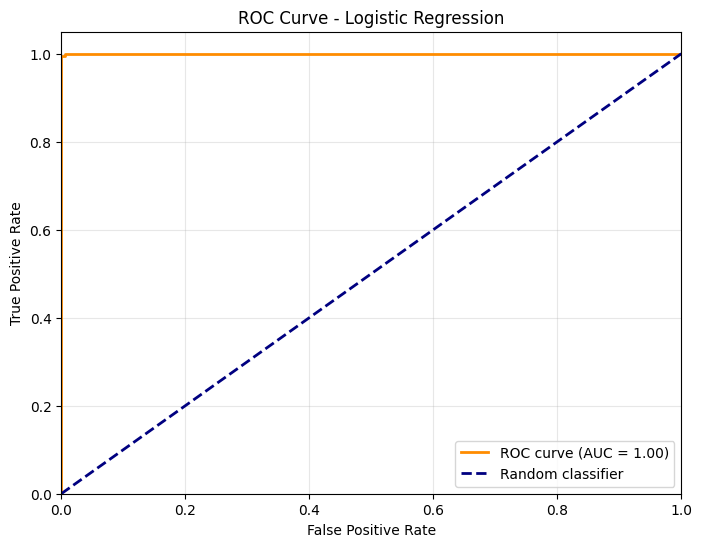

ROC AUC Score: 1.0000
Optimal threshold: 0.4804
At optimal threshold - TPR: 0.9938, FPR: 0.0000

=== THRESHOLD ANALYSIS ===
Threshold 0.300: Precision=0.994, Recall=0.994, F1=0.994
Threshold 0.500: Precision=1.000, Recall=0.988, F1=0.994
Threshold 0.700: Precision=1.000, Recall=0.969, F1=0.984
Threshold 0.480: Precision=1.000, Recall=0.994, F1=0.997


In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

# Find optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At optimal threshold - TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")

# Additional metrics at different thresholds
print("\n=== THRESHOLD ANALYSIS ===")
thresholds_to_check = [0.3, 0.5, 0.7, optimal_threshold]
for threshold in thresholds_to_check:
    y_pred_threshold = (y_test_proba >= threshold).astype(int)
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    
    print(f"Threshold {threshold:.3f}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       147
      Hacked       1.00      0.99      0.99       160

    accuracy                           0.99       307
   macro avg       0.99      0.99      0.99       307
weighted avg       0.99      0.99      0.99       307



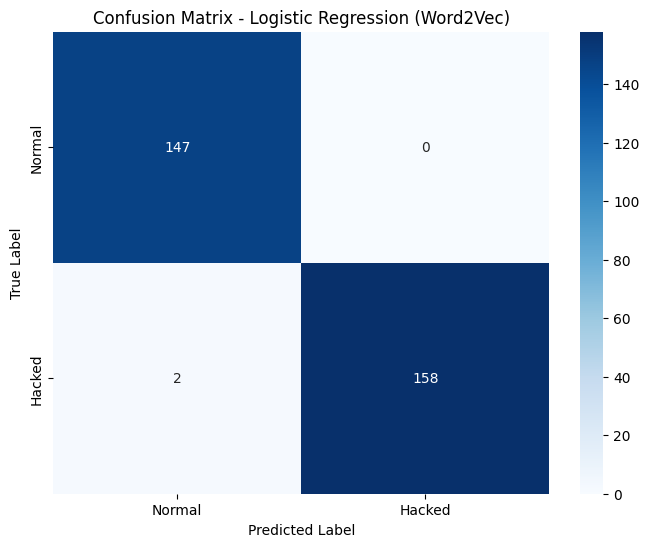

In [11]:
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Hacked']))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Hacked'],
            yticklabels=['Normal', 'Hacked'])
plt.title('Confusion Matrix - Logistic Regression (Word2Vec)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Testing with New Samples

This section demonstrates how to use the trained model to classify new website content.

### The `predict_website()` function:
1. **Input**: Raw HTML content as text
2. **Transform**: Apply the same TF-IDF transformation used during training
3. **Predict**: Use logistic regression to classify as Normal/Hacked
4. **Output**: Classification result with confidence percentage

We test with sample texts including both normal website content and typical hacker messages.

In [12]:
def predict_website(html_content):
    """Predict if a website is hacked or normal"""
    tokens = preprocess_text(html_content)
    html_vec = document_vector(tokens, w2v_model).reshape(1, -1)
    prediction = logistic_model.predict(html_vec)[0]
    probability = logistic_model.predict_proba(html_vec)[0]
    result = "Hacked" if prediction == 1 else "Normal"
    confidence = probability[prediction] * 100
    return result, confidence

test_samples = [
    "Welcome to our website! We offer great products and services.",
    "HACKED BY ANONYMOUS! Your site has been compromised!",
    "Contact us for more information about our company.",
    "Hacked By Shield Iran! We Are N3TC4t - Nazila Blackhat"
]

print("=== TESTING WITH NEW SAMPLES ===")
for i, sample in enumerate(test_samples, 1):
    result, confidence = predict_website(sample)
    print(f"Sample {i}: {result} (Confidence: {confidence:.2f}%)")
    print(f"Text: {sample[:100]}...")
    print("-" * 50)

=== TESTING WITH NEW SAMPLES ===
Sample 1: Normal (Confidence: 97.25%)
Text: Welcome to our website! We offer great products and services....
--------------------------------------------------
Sample 2: Hacked (Confidence: 99.89%)
Text: HACKED BY ANONYMOUS! Your site has been compromised!...
--------------------------------------------------
Sample 3: Normal (Confidence: 99.15%)
Text: Contact us for more information about our company....
--------------------------------------------------
Sample 4: Hacked (Confidence: 99.99%)
Text: Hacked By Shield Iran! We Are N3TC4t - Nazila Blackhat...
--------------------------------------------------


In [ ]:
# Export trained model and Word2Vec for Django application
import pickle

with open('logistic_word2vec_model.pkl', 'wb') as f:
    pickle.dump(logistic_model, f)

with open('word2vec_vectorizer_logistic.pkl', 'wb') as f:
    pickle.dump(w2v_model, f)

print("Model and Word2Vec exported as 'logistic_word2vec_model.pkl' and 'word2vec_vectorizer_logistic.pkl'.")

Model and Word2Vec exported as 'logistic_model.pkl' and 'w2v_model.pkl'.
